<a href="https://www.kaggle.com/code/tadesseabateneh/golden-task-2-spam-filter?scriptVersionId=183805623" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Golden Task: Build a spam filter using NLP and machine learning to identify and filter out spam emails

Develop a robust Spam Email Filter using Natural Language Processing (NLP)
techniques and machine learning algorithms. The goal is to create an intelligent
system capable of accurately classifying emails as either spam or legitimate
(ham) based on their content and linguistic features.

# Import Necessary Libraries

In [2]:
# Import libraries
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import warnings
import plotly.express as px
import string
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Data Loading and Intial Exploration

In [4]:
data_path = "/kaggle/input/spam-email-dataset/emails.csv"
data = pd.read_csv(data_path)

In [5]:
spam_df = data.copy()
spam_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Dataset Information

In [6]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


## Statistical Analysis

In [7]:
spam_df.describe().T

,count,mean,std,min,25%,50%,75%,max
spam,5728.0,0.238827,0.426404,0.0,0.0,0.0,0.0,1.0


In [8]:
spam_df.dtypes

text    object
spam     int64
dtype: object

In [9]:
len(spam_df['text'].unique())

5695

# 2. Data Cleaning

## Missing Values

In [10]:
#Check Null values
spam_df.isnull().sum()

text    0
spam    0
dtype: int64

In [11]:
#To check if there are any missing values
is_any_missing_data=spam_df.isna().any().any()
is_any_missing_data

False

**No Missing Values**

## Duplicate Values

In [12]:
spam_df.duplicated().sum()

33

**There are 33 duplicated values that has to be removed**

In [13]:
#Fetch all duplicate values
duplicate=spam_df[spam_df.duplicated(keep='last')]
duplicate.head()

,text,spam
1417,"Subject: day off tuesday stinson , i would l...",0
1508,Subject: re : enron weather research good aft...,0
1532,Subject: schedule and more . . dr . kaminski ...,0
1667,"Subject: re : summer work . . jinbaek , this...",0
1749,"Subject: term paper dr . kaminski , attached...",0


In [14]:
#Remove Duplicate Records
spam_df.drop_duplicates(inplace=True)
spam_df.duplicated().sum()

0

# 3. Data Preprocessing

**Rename Column names**

In [15]:
# Rename names columns
spam_df=spam_df.rename(columns={'spam':'label'})

In [16]:
spam_df["length"] = spam_df["text"].apply(len)
spam_df.sort_values(by='length', ascending=False).head(3)

,text,label,length
2650,Subject: from the enron india newsdesk - april...,0,43952
1380,Subject: from the enron india newsdesk - april...,0,43937
2338,Subject: from the enron india newsdesk - april...,0,31055


## Distribution of Spam and Ham Emails

In [20]:
import plotly.express as px

# Get value counts and reset the index
counts = spam_df['label'].value_counts().reset_index()
counts.columns = ['Label', 'Count']

# Create a bar plot using Plotly Express with default color settings
fig = px.bar(counts, x='Label', y='Count', color='Label', color_discrete_sequence=px.colors.qualitative.Plotly)

# Update layout for title and axis titles
fig.update_layout(title='Number of Spam and Legitimate Emails', xaxis_title='Label', yaxis_title='Count')

# Update x-axis for tick values and text
fig.update_xaxes(tickvals=[0, 1], ticktext=['Legitimate', 'Spam'])

# Show the figure
fig.show()


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

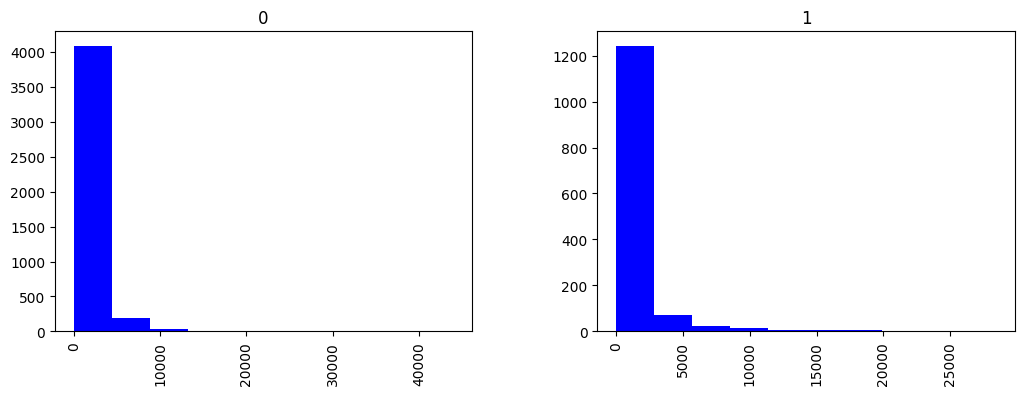

In [22]:
spam_df.hist(column = 'length', by ='label',figsize=(12,4), bins = 10,color='blue')

## Further Processing

* **Remove Punctuations:** Strip out punctuation marks from the text to focus on the words themselves.
* **Lowering the Case:** Convert all text to lowercase to ensure uniformity and improve matching.
* **Remove Stop Words:** Eliminate common, non-informative words (e.g., "and", "the") that don't contribute to the analysis.
* **Lemmatization:** Reduce words to their base or root form (e.g., "running" to "run") for better consistency.
* **Identify Spam and Legit Words Using N-Gram Model:** Use N-grams (sequences of N words) to detect patterns and frequently occurring word combinations in spam and legitimate (ham) emails.

In [23]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [24]:
def preprocess_text(text):
    # Remove punctuation
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])

    # Lowercase the text
    no_punctuation_lower = no_punctuation.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(no_punctuation_lower)

    # Remove stopwords and non-alphabetic characters, and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords.words('english') and word.isalpha()]

    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text


In [25]:
spam_df["preprocessed_text"] = spam_df["text"].apply(preprocess_text)
spam_df.head()

,text,label,length,preprocessed_text
0,Subject: naturally irresistible your corporate...,1,1484,subject naturally irresistible corporate ident...
1,Subject: the stock trading gunslinger fanny i...,1,598,subject stock trading gunslinger fanny merrill...
2,Subject: unbelievable new homes made easy im ...,1,448,subject unbelievable new home made easy im wan...
3,Subject: 4 color printing special request add...,1,500,subject color printing special request additio...
4,"Subject: do not have money , get software cds ...",1,235,subject money get software cd software compati...


## N-gram Plot

Let's define a function `plot_ngrams` visualize the most frequent N-grams (sequences of N words) in a given set of texts. It then applies this function to spam and non-spam messages from a dataset to compare their top bigrams (N-grams of size 2).

### Function: `plot_ngrams`
1. **Initialize Count Vectorizer**: Sets up a count vectorizer to extract N-grams from the texts.
2. **Fit and Transform Texts**: Converts the texts into a matrix of N-gram counts.
3. **Get Feature Names**: Retrieves the N-gram feature names.
4. **Sum N-gram Occurrences**: Totals the occurrences of each N-gram.
5. **Create N-gram Dictionary**: Maps N-grams to their counts.
6. **Sort N-grams**: Orders the N-grams by frequency in descending order.
7. **Select Top N-grams**: Chooses the top N N-grams based on their counts.
8. **Plot N-grams**: Plots the top N-grams using Seaborn's barplot.

### Visualization
1. **Filter Messages**: Separates spam and non-spam messages.
2. **Create Subplots**: Sets up side-by-side plots.
3. **Plot Top Bigrams**: Uses `plot_ngrams` to visualize the top bigrams in spam and non-spam messages.
4. **Display Plots**: Adjusts layout and displays the plots.


In [27]:
def plot_ngrams(ax, texts, ngram_range=(2, 2), num_top_ngrams=25, title=''):
    # Initialize count vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    
    # Fit and transform the texts
    X = vectorizer.fit_transform(texts)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum the occurrences of each n-gram
    ngram_counts = X.sum(axis=0).A1
    
    # Create a dictionary of n-grams and their counts
    ngram_dict = dict(zip(feature_names, ngram_counts))
    
    # Sort the dictionary by counts in descending order
    sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Select top N n-grams
    top_ngrams = sorted_ngrams[:num_top_ngrams]
    
    # Plot the top N n-grams
    sns.barplot(ax=ax, x=[ngram[1] for ngram in top_ngrams],
                y=[ngram[0] for ngram in top_ngrams],
                orient="h",
                width=0.5,
                palette='Spectral')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-gram')
    ax.set_title(title)

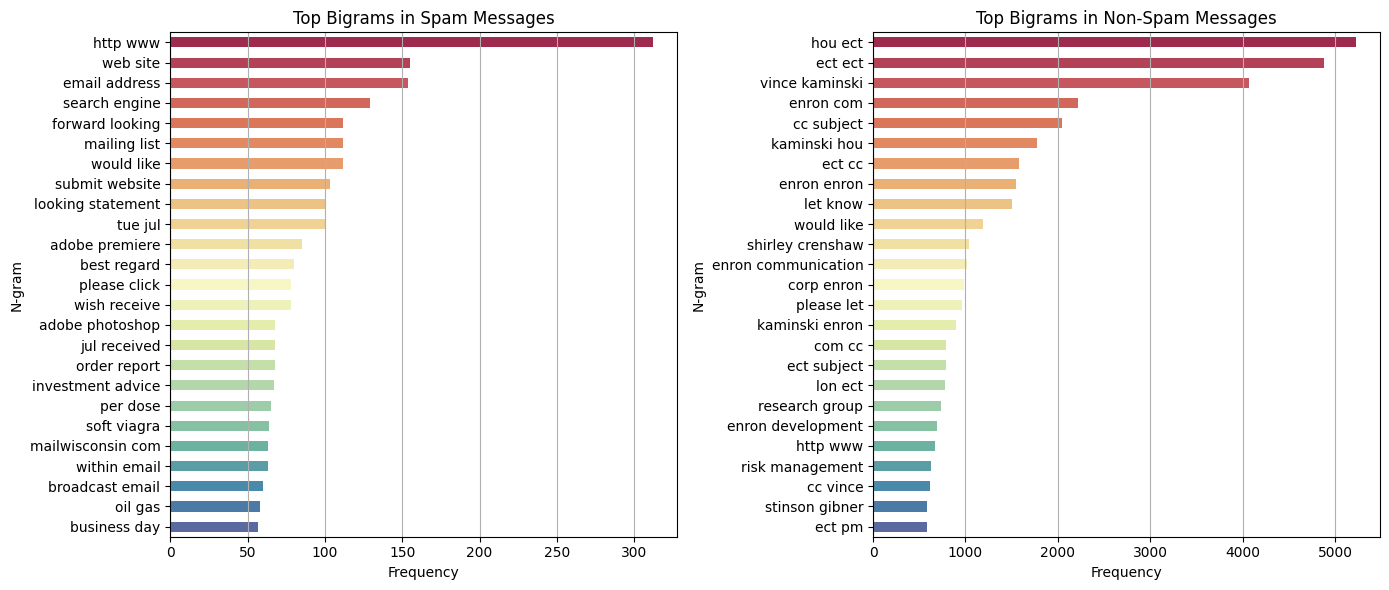

In [28]:
# Filter spam and non-spam messages
spam_texts = spam_df[spam_df['label'] == 1]['preprocessed_text']
non_spam_texts = spam_df[spam_df['label'] == 0]['preprocessed_text']

#Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ngrams(axes[0], spam_texts, title='Top Bigrams in Spam Messages')
plot_ngrams(axes[1], non_spam_texts, title='Top Bigrams in Non-Spam Messages')
axes[0].grid(axis='x')
axes[1].grid(axis='x')
plt.tight_layout()
plt.show()

# 4. Feature Engineering

### 1. Count Vectorizer
Transforms text data into a matrix of token (word) counts. Each entry in the matrix represents the frequency of a word in a specific document, providing a straightforward numerical representation of the text suitable for machine learning models.

In [29]:
# Initialize count vectorizer
vectorizer = CountVectorizer()

# Bag of words
bow_text = vectorizer.fit_transform(spam_df["preprocessed_text"])

# Fetch the vocabulary set
print(f"10 Bag Of Words Features: {vectorizer.get_feature_names_out()[100:110]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

10 Bag Of Words Features: ['absorb' 'absorbing' 'absorbowac' 'absorbs' 'absorption' 'absoutely'
 'abspielt' 'abstained' 'abstract' 'abstractive']
Total number of vocab words: 30962


In [30]:
# Convert strings to vectors using BoW
transformed_bow = vectorizer.transform(spam_df["preprocessed_text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {transformed_bow.shape}")
print(f"Amount of non-zero occurrences: {transformed_bow.nnz}")

Shape of sparse matrix: (5695, 30962)
Amount of non-zero occurrences: 487517


### 2. TF-IDF Vectorizer (Term Frequency-Inverse Document Frequency)
Converts text data into a matrix where each entry reflects the importance of a word in a document relative to the entire corpus. This is calculated by multiplying term frequency (how often a word appears in a document) by inverse document frequency (how common or rare a word is across all documents). This technique helps emphasize unique words and diminish the influence of commonly occurring terms, improving model performance by highlighting significant features.

In [31]:
# TF-IDF
tfidf_transformer = TfidfTransformer().fit(transformed_bow)

# Transform entire BoW into tf-idf corpus
text_tfidf = tfidf_transformer.transform(transformed_bow)
print(text_tfidf.shape)

(5695, 30962)


# 5. Model Building

In this notebook, I am gonna use the following classification models

1. **Support Vector Machine**
2. **Random Forest**
3. **Decision Tree**
4. **Naive Bayas**
5. **XBoost Classifier**

## Split the dataset into traning and testing set

In [32]:
# Split the dataset to train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    text_tfidf, spam_df["label"], test_size=0.2
)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4556, 30962)
train dataset label size: (4556,)
test dataset features size: (1139, 30962)
test dataset label size: (1139,)


# Define the Model - with Metrics, Classification Report, Confusion Matrix Visualization

Let's define the `evaluate_model` function to assesses the performance of a given machine learning model on test data, calculating and printing various metrics. Here's a detailed breakdown:

### Function: `evaluate_model`
1. **Predict Labels**: Uses the model to predict labels for the test data (`x_test`).
2. **Confusion Matrix**: Computes the confusion matrix to derive true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).
3. **Performance Metrics**:
    - **Accuracy**: Proportion of correct predictions.
    - **Recall**: Proportion of actual positives correctly identified.
    - **Precision**: Proportion of positive predictions that are correct.
    - **F1-score**: Harmonic mean of precision and recall.
    - **Specificity**: Proportion of actual negatives correctly identified.
    - **Miss Rate**: Proportion of actual positives incorrectly identified as negatives.
    - **Mean Accuracy**: Average accuracy from cross-validation.
    - **Mean Square Error (MSE)**: Included but not applicable for classification tasks.
4. **Classification Report**: Generates a detailed report with precision, recall, and F1-score for each class.
5. **Print Metrics**: Displays the metrics and confusion matrix in a formatted output.
6. **Plot Confusion Matrix**: Visualizes the confusion matrix using `ConfusionMatrixDisplay`.


In [41]:
def evaluate_model(model, x_test, y_test, model_name="Model"):

    # Predict labels on testing data
    y_pred = model.predict(x_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract TP, TN, FP, FN
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculate various performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = TN / (TN + FP)
    miss_rate = FN / (FN + TP)

    # Calculate mean accuracy using cross-validation
    mean_accuracy = cross_val_predict(model, x_train, y_train, cv=10).mean()

    # Calculate mean square error (for regression tasks, not applicable here)
    mse = mean_squared_error(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-score": f1,
        "Specificity": specificity,
        "Miss Rate": miss_rate,
        "Mean Accuracy": mean_accuracy,
        "Mean Square Error": mse,
        "Classification Report": classification_rep
    }
    # Print evaluation metrics
    print(f"\033[1m EVALUATION METRICS ({model_name}) \033[0m")
    print(f"\n \033 ---------------------------------------------------------------- \033[0m")
    print("\nTrue Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)
    print("\nAccuracy   : ", accuracy)
    print("Recall       : ", recall)
    print("Precision    : ", precision)
    print("F1-score     : ", f1)
    print("Specificity  : ", specificity)
    print("Miss Rate    : ", miss_rate)
    print("Mean Accuracy: ", mean_accuracy)
    print("Mean Square Error:", mse)  # Not applicable for classification
    print(f" \033 ---------------------------------------------------------------- \033[0m")

    # Print classification report
    print("\033[1m Classification Report: \033[0m")
    print(classification_report(y_test, y_pred))
    print(f"\n \033 ---------------------------------------------------------------- \033[0m")
    print("\033[1m Confusion Matrix \033[0m")
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='bone_r')  # specify the colormap for better visualization
    plt.show()
    return metrics,y_pred

### 1. Support Vector Machine (SVM)
A powerful classification algorithm that finds the optimal hyperplane separating different classes by maximizing the margin between them. SVM is effective in high-dimensional spaces and is used for its accuracy and efficiency in text classification tasks.


 EVALUATION METRICS (SVM) 

  ---------------------------------------------------------------- 

True Positives (TP): 252
True Negatives (TN): 872
False Positives (FP): 0
False Negatives (FN): 15

Accuracy   :  0.9868305531167691
Recall       :  0.9438202247191011
Precision    :  1.0
F1-score     :  0.9710982658959537
Specificity  :  1.0
Miss Rate    :  0.056179775280898875
Mean Accuracy:  0.23375768217734855
Mean Square Error: 0.013169446883230905
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       872
           1       1.00      0.94      0.97       267

    accuracy                           0.99      1139
   macro avg       0.99      0.97      0.98      1139
weighted avg       0.99      0.99      0.99      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


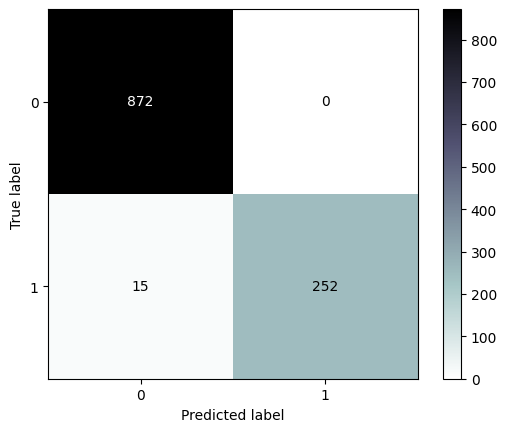

In [42]:
# Train SVM model
svm_model = SVC()
svm_model.fit(x_train, y_train)

# Evaluate SVM model
svm_metrics,y_pred_svm = evaluate_model(svm_model, x_test, y_test, model_name="SVM")

### 2. Random Forest
An ensemble learning method that constructs multiple decision trees during training and outputs the mode of their predictions for classification. It improves accuracy and robustness by reducing overfitting and variance, making it well-suited for handling large datasets with complex patterns.

 EVALUATION METRICS (Random Forest) 

  ---------------------------------------------------------------- 

True Positives (TP): 241
True Negatives (TN): 872
False Positives (FP): 0
False Negatives (FN): 26

Accuracy   :  0.9771729587357331
Recall       :  0.9026217228464419
Precision    :  1.0
F1-score     :  0.9488188976377953
Specificity  :  1.0
Miss Rate    :  0.09737827715355805
Mean Accuracy:  0.22190517998244075
Mean Square Error: 0.0228270412642669
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       872
           1       1.00      0.90      0.95       267

    accuracy                           0.98      1139
   macro avg       0.99      0.95      0.97      1139
weighted avg       0.98      0.98      0.98      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


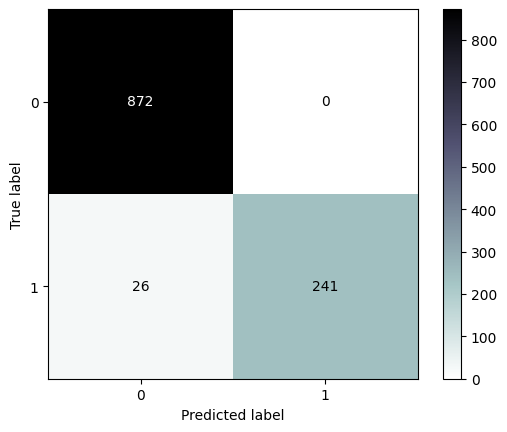

In [35]:
# Train Random Forest model
randomForest_model = RandomForestClassifier()
randomForest_model.fit(x_train, y_train)

# Evaluate Random Forest model
rf_metrics,y_pred_rf = evaluate_model(randomForest_model, x_test, y_test, model_name="Random Forest")

### 3. Decision Tree
A tree-structured model where nodes represent feature decisions, and branches represent outcomes, leading to a final decision at the leaf nodes. Decision Trees are easy to interpret and visualize but can be prone to overfitting if not properly pruned.

 EVALUATION METRICS (Decision Tree) 

  ---------------------------------------------------------------- 

True Positives (TP): 243
True Negatives (TN): 853
False Positives (FP): 19
False Negatives (FN): 24

Accuracy   :  0.9622475856014048
Recall       :  0.9101123595505618
Precision    :  0.9274809160305344
F1-score     :  0.9187145557655955
Specificity  :  0.9782110091743119
Miss Rate    :  0.0898876404494382
Mean Accuracy:  0.24100087796312555
Mean Square Error: 0.03775241439859526
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       872
           1       0.93      0.91      0.92       267

    accuracy                           0.96      1139
   macro avg       0.95      0.94      0.95      1139
weighted avg       0.96      0.96      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix

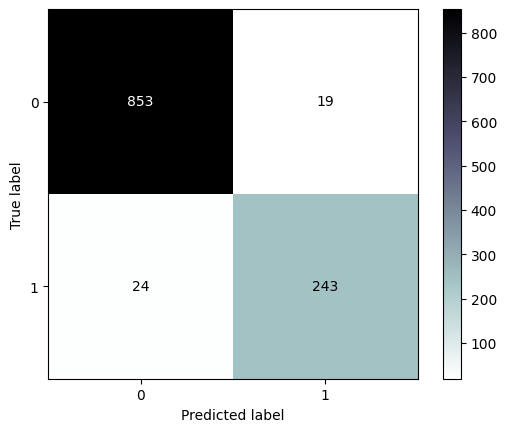

In [36]:
# Train Decision Tree Model
decisionTree_model = DecisionTreeClassifier()
decisionTree_model.fit(x_train, y_train)

# Evaluate
dt_metrics,y_pred_dt = evaluate_model(decisionTree_model, x_test, y_test, model_name="Decision Tree")

### 4. Naive Bayes
A probabilistic classifier based on Bayes' theorem with an assumption of independence between features. It is highly efficient and works particularly well for text classification, such as spam detection, due to its simplicity and effectiveness in handling large vocabularies.

 EVALUATION METRICS (Naive Bayes) 

  ---------------------------------------------------------------- 

True Positives (TP): 243
True Negatives (TN): 853
False Positives (FP): 19
False Negatives (FN): 24

Accuracy   :  0.9622475856014048
Recall       :  0.9101123595505618
Precision    :  0.9274809160305344
F1-score     :  0.9187145557655955
Specificity  :  0.9782110091743119
Miss Rate    :  0.0898876404494382
Mean Accuracy:  0.24363476733977174
Mean Square Error: 0.03775241439859526
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       872
           1       0.93      0.91      0.92       267

    accuracy                           0.96      1139
   macro avg       0.95      0.94      0.95      1139
weighted avg       0.96      0.96      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


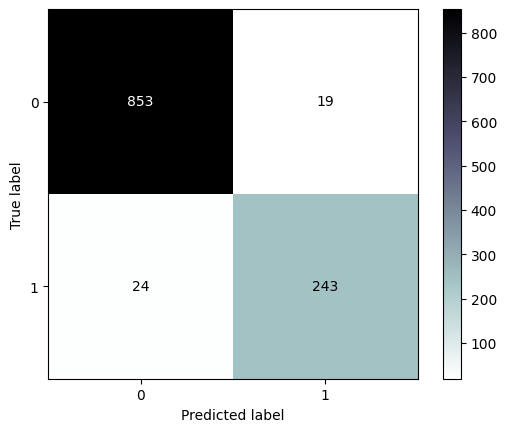

In [37]:
# Define Naive Bayas model
NaiveBayes_model = GaussianNB()
NaiveBayes_model.fit(x_train.toarray(), y_train)

# Evaluate
nb_metrics,y_pred_nb = evaluate_model(decisionTree_model, x_test.toarray(), y_test, model_name="Naive Bayes")

### 5. XGBoost Classifier
An optimized gradient boosting algorithm designed for speed and performance. XGBoost builds an ensemble of weak learners (typically decision trees) in a sequential manner, focusing on reducing errors from previous iterations. It is known for its high accuracy and scalability in various classification tasks.

 EVALUATION METRICS (XGBoost) 

  ---------------------------------------------------------------- 

True Positives (TP): 258
True Negatives (TN): 851
False Positives (FP): 21
False Negatives (FN): 9

Accuracy   :  0.9736611062335382
Recall       :  0.9662921348314607
Precision    :  0.9247311827956989
F1-score     :  0.945054945054945
Specificity  :  0.9759174311926605
Miss Rate    :  0.033707865168539325
Mean Accuracy:  0.25877963125548725
Mean Square Error: 0.02633889376646181
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       872
           1       0.92      0.97      0.95       267

    accuracy                           0.97      1139
   macro avg       0.96      0.97      0.96      1139
weighted avg       0.97      0.97      0.97      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


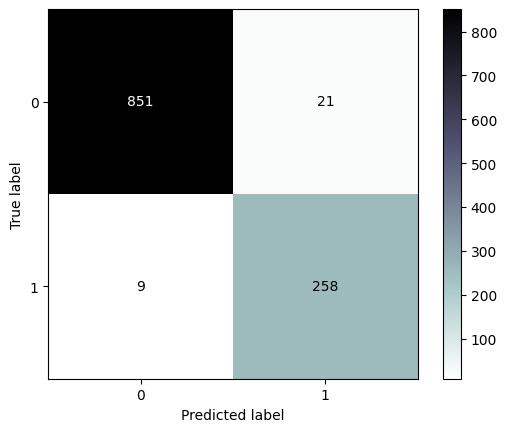

In [38]:
# Create the XGBoost model
xgboost_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',  # Use 'multi:softmax' for multi-class classification
    eval_metric='logloss'
)

# Fit the model to the training data
xgboost_model.fit(x_train, y_train)

# Predict using the trained model
#y_pred_xgb = xgboost_model.predict(x_test)

# Evaluate the model
xgb_metrics, y_pred_xgb = evaluate_model(xgboost_model, x_test, y_test, model_name="XGBoost")


## Model Comparision

In [43]:
svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred_rf)
auc_rfc = auc(rf_fpr, rf_tpr)
dt_fpr, dt_tpr, threshold = roc_curve(y_test, y_pred_dt)
auc_rfc = auc(dt_fpr, dt_tpr)
nb_fpr, nb_tpr, threshold = roc_curve(y_test, y_pred_nb)
auc_rfc = auc(nb_fpr, nb_tpr)
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(xgb_fpr, xgb_tpr)

## ROC and AUC Visualization

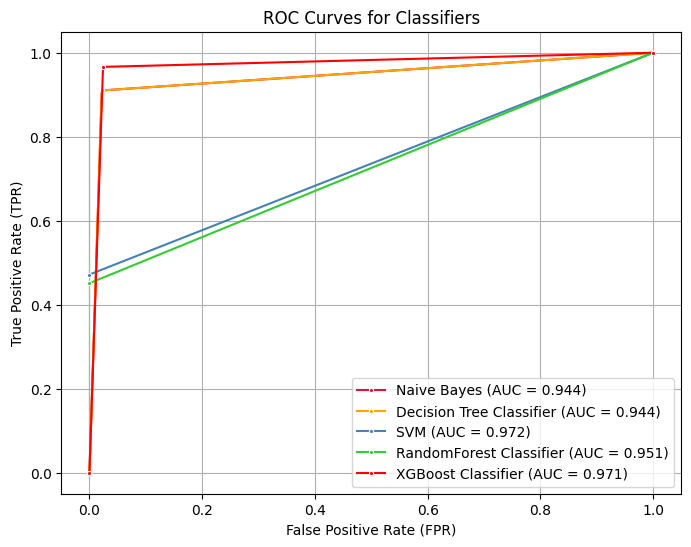

In [44]:
classifiers = {
    'Naive Bayes': (y_pred_nb, nb_fpr, nb_tpr),
    'Decision Tree Classifier': (y_pred_dt, dt_fpr, dt_tpr),
    'SVM': (y_pred_svm, svm_fpr, svm_tpr),
    'RandomForest Classifier': (y_pred_rf, rf_fpr, rf_tpr),
    'XGBoost Classifier': (y_pred_xgb, xgb_fpr, xgb_tpr)
}

plt.figure(figsize=(8, 6), dpi=100)
colors=['crimson','orange','steelblue','limegreen', 'red']


for i, (clf_name, (y_pred, fpr, tpr)) in enumerate(classifiers.items()):
    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})', color=colors[i])

# Loop through classifiers and plot ROC curves
#for clf_name, (y_pred, fpr, tpr) in classifiers.items():
#    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
#    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})')  # Use seaborn lineplot

# plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Classifiers')
plt.grid(True)
plt.legend()
plt.show()

In [45]:
# Extract metric names and values
metric_names = list(svm_metrics.keys())
svm_values = [svm_metrics[key] for key in metric_names if key != 'Classification Report']
rf_values = [rf_metrics[key] for key in metric_names if key != 'Classification Report']
dt_values = [dt_metrics[key] for key in metric_names if key != 'Classification Report']
nb_values = [nb_metrics[key] for key in metric_names if key != 'Classification Report']
xgb_values = [xgb_metrics[key] for key in metric_names if key != 'Classification Report']

length = len(metric_names)-1

length_svm = len(svm_values)
length_rf = len(rf_values)
length_dt = len(dt_values)
length_nb = len(nb_values)
length_xgb = len(xgb_values)

print(length,length_svm,length_rf,length_dt,length_nb, length_xgb)
print()

8 8 8 8 8 8



## Bar Chart Comparision of Metrix

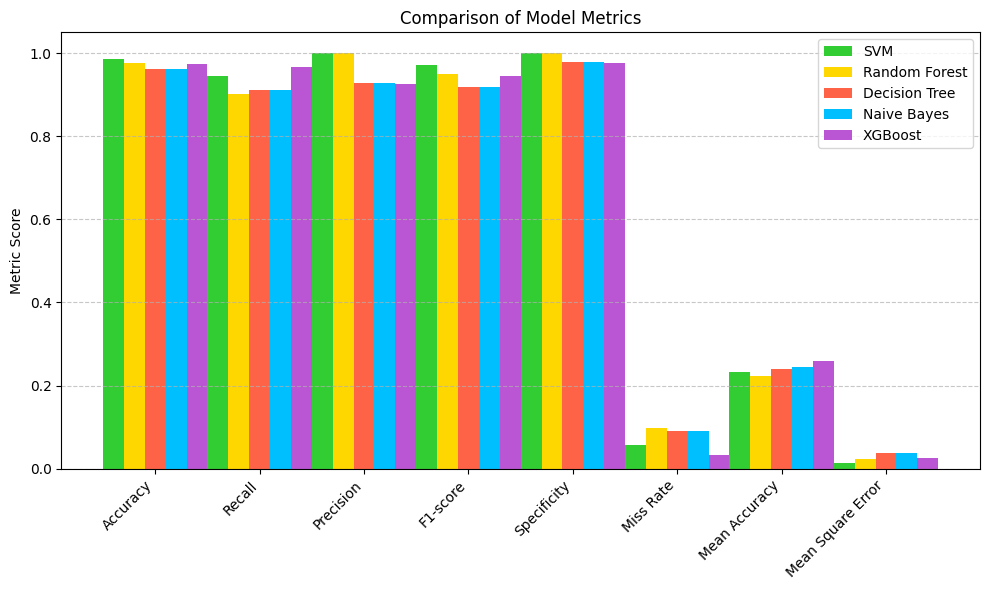

In [47]:
# Create a bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(metric_names) - 1)  # Assuming metric_names has the names excluding 'Classification Report'
width = 0.2

# Plot bars for each model with different colors
plt.bar(x - 2*width, svm_values, width, label='SVM', color='limegreen')
plt.bar(x - width, rf_values, width, label='Random Forest', color='gold')
plt.bar(x, dt_values, width, label='Decision Tree', color='tomato')
plt.bar(x + width, nb_values, width, label='Naive Bayes', color='deepskyblue')
plt.bar(x + 2*width, xgb_values, width, label='XGBoost', color='mediumorchid')

plt.xticks(x, [name for name in metric_names if name != 'Classification Report'], rotation=45, ha='right')
plt.ylabel('Metric Score')
plt.title('Comparison of Model Metrics')
plt.legend()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **|| END OF NOTEBOOK ||**